In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Load a real file for visual inspection.

In [2]:
test_path = "onderive_data_2/12Hz/layer368.csv"
test = pd.read_csv(test_path,header=0,index_col=0)

In [3]:
def expand_df(df):
    r = df.loc[:,("X","Y")].values
    # Orientation
    v = r[2:,:] - r[:-2,:]
    v = np.r_[[r[1,:]-r[0,:]],v,[r[-1,:]-r[-2,:]]]
    theta = np.arctan2(v[:,0],v[:,1])
    # Acceleration
    v_mid = r[1:,:] - r[:-1,:]
    a = v_mid[1:,:] - v_mid[:-1,:]
    a = np.r_[[v_mid[0,:]],a,[v_mid[-1,:]]]
    accel = np.einsum('ki,kj->k',a,v) / np.linalg.norm(v)
    # Add columns
    df["Orientation"] = theta
    df["Speed"] = np.linalg.norm(v,axis=1)
    df["Acceleration"] = accel
    return df

In [4]:
test = expand_df(test)

In [5]:
test.describe()

,P,X,Y,Photodiode,Spot Centroid X,Spot Centroid Y,Spot area (um2),Spot major axis (um),Spot minor axis (um),Spot orientation,...,Layer,Spatter number,Spatter total area,Spatter mean area,Spatter median area,Spatter mean mean intensity,Spatter median mean intensity,Orientation,Speed,Acceleration
count,287296.000000,287296.000000,287296.000000,287296.000000,254904.000000,254904.000000,254904.000000,2.540100e+05,254009.000000,254010.000000,...,287296.0,40316.000000,40316.000000,40316.000000,40316.000000,40316.000000,40316.000000,287296.000000,287296.000000,2.872960e+05
mean,167.666808,-526.981367,590.406343,296590.359121,61.433014,68.678012,15459.223782,inf,130.216547,46.989157,...,8.0,1.182037,20.384599,17.203979,17.133638,27.002994,26.987512,-0.182938,62.323122,2.408747e-08
std,69.249870,52670.531350,53327.635889,4260.319097,2.675993,2.515649,5545.626353,NaN,24.226818,30.956123,...,0.0,0.484691,19.648133,13.996556,13.981826,3.446359,3.445608,2.039812,64.249250,2.138869e-02
min,-7.468680,-76344.214727,-77247.914961,283462.000000,55.000000,62.000000,5285.500000,9.803061e+01,54.872860,0.000000,...,8.0,1.000000,5.500000,5.500000,5.500000,21.846154,21.846154,-3.141381,0.158788,-6.516779e-01
25%,123.808739,-43440.586372,-25917.850098,294384.000000,59.000000,67.000000,11532.000000,1.600864e+02,111.740026,31.503418,...,8.0,1.000000,9.000000,8.500000,8.500000,24.636364,24.631579,-2.564510,35.047583,-6.798155e-03
50%,183.375061,-17775.143696,18279.475571,296798.000000,61.000000,69.000000,15376.000000,1.827356e+02,134.214137,43.147961,...,8.0,1.000000,14.500000,13.000000,13.000000,26.350000,26.333333,0.070343,62.111965,1.049452e-06
75%,231.646805,25752.029031,37260.979272,299071.000000,63.000000,70.000000,19220.000000,2.049182e+02,147.860583,53.210846,...,8.0,1.000000,25.000000,20.500000,20.500000,28.345467,28.313323,0.977954,69.910324,6.823840e-03
max,389.685913,76328.271758,77366.741875,392007.000000,68.000000,76.000000,100424.500000,inf,820.273216,180.000000,...,8.0,7.000000,748.000000,170.500000,170.500000,51.933333,51.933333,3.141593,545.666033,4.344864e-01


(72000.0, 74000.0)

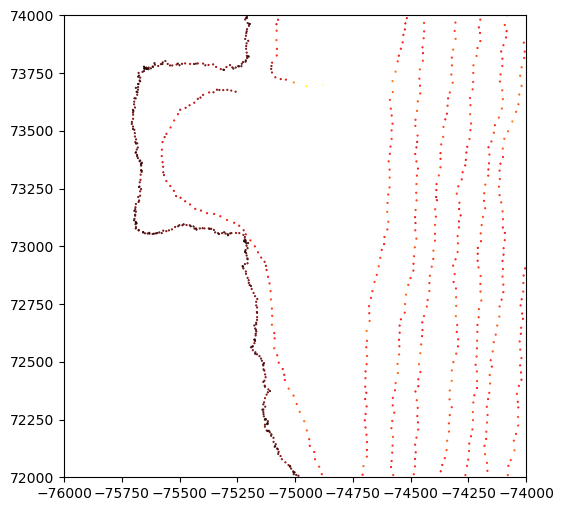

In [23]:
fig,ax = plt.subplots(figsize=(10,6))

ax.scatter(test[test.loc[:,"P"]>0.0].loc[:,"X"].values,test[test.loc[:,"P"]>0.0].loc[:,"Y"].values,
           c=test[test.loc[:,"P"]>0.0].loc[:,"Speed"].values,
           s=0.3,
           cmap="hot")
ax.set_aspect("equal")
# ax.set_xlim([-77000,-66000])
# ax.set_ylim([68000,78000])
ax.set_xlim([-76000,-74000])
ax.set_ylim([72000,74000])

# Simulation

In [7]:
w = 0.2 # Defines the hatch spacing

Focussing on 2D scan paths, the simplest shape is a triangle with sides 1, 2, 3

In [8]:
a1,b1,c1 = 0.1,0.6,0.2
a2,b2,c2 = 1.1,0.01,-0.3
a3,b3,c3 = -0.2,-0.1,0.6

num_sides = 3

In [9]:
def intersection(a1,b1,c1,a2,b2,c2):
    denom = a1*b2-a2*b1
    if denom == 0.0:
        # Lines are parallel
        return None,None
    else:
        return (c1*b2 - c2*b1)/denom, (a1*c2 - a2*c1)/denom


In [10]:
def seg_intersect(a,b,c,x1,x2,y1,y2):
    # Intersection of a line (a,b,c) with a line segment (x1,y1,x2,y2)
    # Determine a,b,c for line segment
    th = np.arctan2(y1-y2,x2-x1) ; a_ = np.sin(th) ; b_ = np.cos(th) ; c_ = a_*x1 + b_*y1
    x,y = intersection(a,b,c,a_,b_,c_)
    if x is not None and y is not None:
        if x <= max(x1,x2) and x >= min(x1,x2) and y <= max(y1,y2) and y >= min(y1,y2):
            return x,y
        
    return None,None
    

In [11]:
def point_rep(*lines):
    num_lines = len(lines)
    lines_x = np.empty((num_lines,num_lines),dtype=np.float64)
    lines_x.fill(np.nan)
    lines_y = np.empty((num_lines,num_lines),dtype=np.float64)
    lines_y.fill(np.nan)
    for i,(a,b,c) in enumerate(lines):
        # Per LINE
        for j,(a_,b_,c_) in enumerate(lines):
            if i<j:
                x_ij,y_ij = intersection(a,b,c,a_,b_,c_)
                if x_ij is not None and y_ij is not None:
                    lines_x[i,j] = x_ij ; lines_x[j,i] = x_ij
                    lines_y[i,j] = y_ij ; lines_y[j,i] = y_ij
    # Calculate CoM
    com_x,com_y = np.ma.masked_invalid(lines_x).sum()/(2*num_lines), np.ma.masked_invalid(lines_y).sum()/(2*num_lines)
    
    return lines_x,lines_y,com_x,com_y

In [12]:
def inner_shape(com_x,com_y,*lines):
    # Line given by a,b,c where a,b define normal to line. 
    new_lines = []
    for (a,b,c) in lines:
        if np.abs(a*com_x+b*com_y-c-w*np.sqrt(a**2+b**2)) < np.abs(a*com_x+b*com_y-c+w*np.sqrt(a**2+b**2)):
            c_new = c + w*np.sqrt(a**2+b**2)
        else:
            c_new = c - w*np.sqrt(a**2+b**2)
        new_lines.append((a,b,c_new))
        
    return new_lines
        

In [13]:
def gen_hatch(theta,lines_x,lines_y):
    # a,b defining the hatch lines
    a_h = -np.sin(theta) ; b_h = np.cos(theta)
    c_h_array = a_h*lines_x + b_h*lines_y
    inds = np.triu_indices_from(c_h_array,k=1)
    dists = np.abs(c_h_array[inds][:,None] - c_h_array[inds][None,:])
    c_h_i,c_h_f = c_h_array[inds][np.array(np.unravel_index(np.argmax(dists),dists.shape))]
    return [(a_h,b_h,c_h) for c_h in np.arange(min(c_h_i,c_h_f),max(c_h_i,c_h_f),w)[1:]]
    

In [14]:
def bezier_3(d,start,control_1,control_2,end,t_samples=100):
    # Cubic bezier curve
    bz = lambda t: (1-t)**3*start[None,:] + 3*(1-t)**2*t*control_1[None,:] + 3*(1-t)*t**2*control_2[None,:] + t**3*end[None,:]
    # Lazy way to do this: generate 100 sample points then resample as required...
    t_ = np.linspace(0.0,1.0,t_samples) ; t = t_[:,None]
    samples = bz(t)
    arc_dists = np.r_[[0.0],np.cumsum(np.linalg.norm(samples[1:] - samples[:-1],axis=1))]
    t_final = np.interp(np.arange(0.0,arc_dists[-1],d),arc_dists,t_)[:,None]
    return bz(t_final)
    

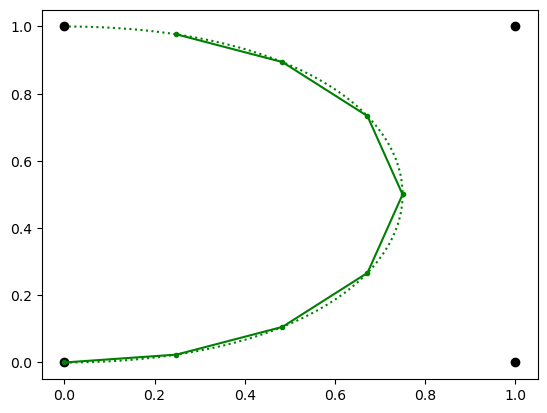

In [18]:
plt.scatter([0,1,1,0],[0,0,1,1],c='k')
plt.plot(
    *bezier_3(0.25,np.array([0,0]),np.array([1,0]),np.array([1,1]),np.array([0,1])).T,
    ".-g"
)
plt.plot(
    *bezier_3(0.01,np.array([0,0]),np.array([1,0]),np.array([1,1]),np.array([0,1])).T,
    ":g"
)

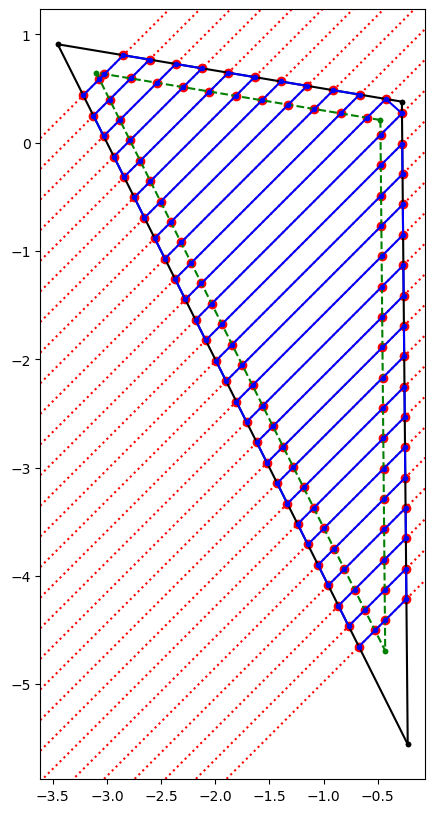

In [15]:
fig,ax = plt.subplots(figsize=(6,10))
lines_x,lines_y,com_x,com_y = point_rep((a1,b1,c1),(a2,b2,c2),(a3,b3,c3))
iline_x,iline_y,_,_ = point_rep(*inner_shape(com_x,com_y,(a1,b1,c1),(a2,b2,c2),(a3,b3,c3)))
for i in range(num_sides):
    plt.plot(lines_x[i][~np.isnan(lines_x[i])],lines_y[i][~np.isnan(lines_y[i])],"k.-")
    plt.plot(iline_x[i][~np.isnan(iline_x[i])],iline_y[i][~np.isnan(iline_y[i])],"g.--")
#plt.scatter(com_x,com_y)
ax.set_aspect("equal")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
hatch = gen_hatch(np.pi/4,iline_x,iline_y)
direction = 1
hatch_pts_x = []
hatch_pts_y = []
for (a_h,b_h,c_h) in hatch:
    plt.plot(xlim,(c_h-a_h*np.array(xlim))/b_h,'r:')
    inters_x = [] # Intersections of this hatch line
    inters_y = []
    for i in range(num_sides):
        x1 , x2   = lines_x[i][~np.isnan(lines_x[i])] ; y1 , y2   = lines_y[i][~np.isnan(lines_y[i])]
        x1_i,x2_i = iline_x[i][~np.isnan(iline_x[i])] ; y1_i,y2_i = iline_y[i][~np.isnan(iline_y[i])]
        x_h , y_h   = seg_intersect(a_h,b_h,c_h,x1,x2,y1,y2)
        x_h_i,y_h_i = seg_intersect(a_h,b_h,c_h,x1_i,x2_i,y1_i,y2_i)
        if x_h is not None and y_h is not None:
            inters_x.append(x_h)
            inters_y.append(y_h)
            plt.scatter(x_h,y_h,c="r")
        if x_h_i is not None and y_h_i is not None:
            plt.scatter(x_h_i,y_h_i,c="r")
            inters_x.append(x_h_i)
            inters_y.append(y_h_i)
    order_ = np.argsort(inters_x) 
    inters_x = np.array(inters_x)[order_][::direction]
    inters_y = np.array(inters_y)[order_][::direction]
    direction *= -1
    hatch_pts_x = np.r_[hatch_pts_x,inters_x]
    hatch_pts_y = np.r_[hatch_pts_y,inters_y]
        
plt.plot(hatch_pts_x,hatch_pts_y,"b.-")
        
        
ax.set_xlim(xlim) ;
ax.set_ylim(ylim) ;
